## Activation demo
This demo will be a walkthrough of how to use the provided activation code.  Activation is a differential equation that responds to a neural input and current activation value.  It describes the change in calcium ion concentration within the muscle which drives actin-myosin interactions and thus muscle contraction.  Activation $a(t) \in [0,1] $.

Generally how activation works:  first give the model a nueral excitation and initial condition $a$, then use a solver to solve the differential equation throughout time.  Here I use scipy.integrate.solve_ivp, however, feel free to use any solver you wish.

Here, I implement 9 different models found in the literature to see how they generate different contraction dynamics. I created one parent class called Activation that houses the general methods that each activation model uses -- underneath this Activation class live the 9 different models of activation dynamics.

First, let's import the necessary libraries for this demo:

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

Next, let's load-up the Activation class and all of the child classes that house the differential equations that we will be integrating.  Each of these 9 models was found in the literature -- the class name corresponds to the first author where I got the activation function from.

In [142]:
class Activation:
    """
    relates nueral excitation and muscle activation.  this is a parent class without methods implemented.
    to use an activation model, use one of the child classes below that either returns adot (the derivative
    of activation) or a itelf (activation) as a function of u (neural input) and a (previous activation)

    Parameters
        u          (float):   unitless excitation value b/w 0-1
        a          (float):   unitless activation value b/w 0-1
        tau_act    (float):   activation timescale 10 ms
        tau_deact  (float):   deactivation timescale 40 ms
    """
    def __init__(self, u, tau_act = 0.01, tau_deact = 0.04):
        self.u = u
        self.tau_act = tau_act
        self.tau_deact = tau_deact
               
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        # maybe give finite differences as adot
        raise Exception('Method implemented in child class')
        
    def a(self, a):
        raise Exception('Method implemented in child class')

In [143]:
class Thelen(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        if self.u >= a:
            adot = (self.u - a) / self.tau_act
        else:
            adot = (self.u - a) / self.tau_deact
        return adot

In [144]:
class Winters(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        if self.u > a:
            tau = self.tau_act * (0.5 + 1.5*a)
        else:
            tau = self.tau_deact / (0.5 + 1.5*a)
        adot = (self.u - a) / tau
        return adot

In [145]:
class Zajac(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        self.beta = self.tau_act / self.tau_deact
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        adot = 1 / self.tau_act * ( self.u - a * (self.beta + (1+self.beta) * self.u) )
        return adot

In [146]:
class Manal(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        self.uo = 0.3085 - self.tau_act * np.cos( np.pi / 4 )
        self.ao = 0.3085 + self.tau_act * np.sin( np.pi / 4 )
        self.m = (self.ao-1) / (self.uo-1)
        self.c = 1 - self.m
        self.beta = (np.exp(self.ao / self.tau_deact) - 1) / self.uo
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        if self.u <= self.uo:
            adot = self.tau_deact * np.log( self.beta * self.u + 1 )
        elif self.u > self.uo:
            adot = self.m * self.u + self.c
        return adot

In [147]:
class Chadwick(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        adot = ( self.u - a ) * (self.u / self.tau_act + (1 - self.u) / self.tau_deact )
        return adot

In [148]:
class Nagano(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        self.t2 = 1 / self.tau_deact
        self.t1 = 1 / (self.tau_act - self.t2)
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        adot = (self.u - a) * (self.t1 * self.u + self.t2)
        return adot

In [149]:
class Rengifo(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        
    def __call__(self, t, a):
        return self.rhs(t, a)
    
    def rhs(self, t, a):
        if self.u >= a:
            adot = -a / self.tau_act + self.u / self.tau_act
        elif a > self.u:
            adot = -a / self.tau_deact + self.u / self.tau_deact
        return adot

In [150]:
class AModel(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        self.A = -2.0
    
    def a(self):
        a = (np.exp(self.tau_act * self.u) - 1) / (np.exp(self.tau_act) - 1)
        return a

In [151]:
class Cavallaro(Activation):
    def __init__(self, u, **kwargs):
        super().__init__(u, **kwargs)
        self.A = -2.0
    
    def a(self):
        a = (self.tau_act**self.u - 1) / (self.tau_act - 1)
        return a

Now with each activation model, let's see how they respond to different neural inputs for $u(t) \in [0,1]$.  For this first example, we'll look at the Thelen model -- considered the 'default' activation function.  We'll activate it with 7 different constant inputs $u(t) = [0.01,0.02,0.05,0.1,0.2,0.5,1.0]$ that are logarithmically spaced following the spacing of US dollar bills.  I will give each activation response the same an initial condition of $a(0) = 0.15$.

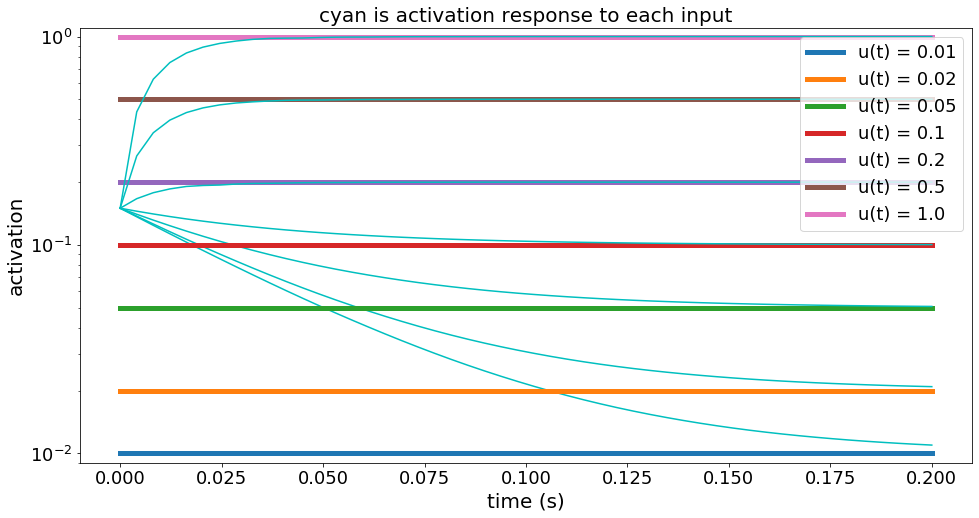

In [152]:
u = [0.01,0.02,0.05,0.1,0.2,0.5,1.0]   # inputs with log spacing following US dollar bill spacing
a = 0.15   # activation initial condition 
t = np.linspace(0,0.2)   # declare time array to integrate over

sols = []   # store solutions to different inputs for later

plt.figure(figsize=(16, 8))
for i in u:
    u = i   # set nueral input
    u_plot = np.ones(t.size) * u

    # use thelen model first
    act_thelen = Thelen(u)
    sol = solve_ivp(act_thelen, [t[0], t[-1]], [a], t_eval=t)
    
    sols.append([sol])
    plt.plot(t,u_plot, linewidth=5,label = 'u(t) = '+str(u))
    plt.plot(t,sol.y.T, c = 'c')#,label = 'activation response')

plt.xlabel('time (s)', fontsize = 20)
plt.ylabel('activation', fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylim(0.009, 1.1)
plt.yscale('log')
plt.legend(fontsize = 18, loc='upper right')
plt.title('cyan is activation response to each input', fontsize=20)
plt.show()
plt.close()

Note that the activation timescale is quicker than the deactivation timescale in the plot above.  Now let's see how each of the 9 different models respond to a constant input over time.  Each are given the same initial condition of $a = 0.1$...

In [155]:
t = np.linspace(0,0.2)   # declare time array to integrate over
u = 0.9   # constant nueral input
u_array = np.ones(t.size) * u
a = 0.1   # activation initial condition 

# all 9 models follow the same structure
act_thelen = Thelen(u_array[-1])
sol = solve_ivp(act_thelen, [t[0], t[-1]], [a], t_eval=t)
a_thelen = sol.y.T

act_winters = Winters(u_array[-1])
sol = solve_ivp(act_winters, [t[0], t[-1]], [a], t_eval=t)
a_winters = sol.y.T

act_zajac = Zajac(u_array[-1])
sol = solve_ivp(act_zajac, [t[0], t[-1]], [a], t_eval=t)
a_zajac = sol.y.T

act_manal = Manal(u_array[-1])
sol = solve_ivp(act_manal, [t[0], t[-1]], [a], t_eval=t)
a_manal = sol.y.T

act_chadwick = Chadwick(u_array[-1])
sol = solve_ivp(act_chadwick, [t[0], t[-1]], [a], t_eval=t)
a_chadwick = sol.y.T

act_nagano = Nagano(u_array[-1])
sol = solve_ivp(act_nagano, [t[0], t[-1]], [a], t_eval=t)
a_nagano = sol.y.T

act_rengifo = Rengifo(u_array[-1])
sol = solve_ivp(act_rengifo, [t[0], t[-1]], [a], t_eval=t)
a_rengifo = sol.y.T

act_amodel = AModel(u_array[-1])
a_amodel = np.ones(t.size) * act_amodel.a()

act_cavallaro = Cavallaro(u_array[-1])
a_cavallaro = np.ones(t.size) * act_cavallaro.a()

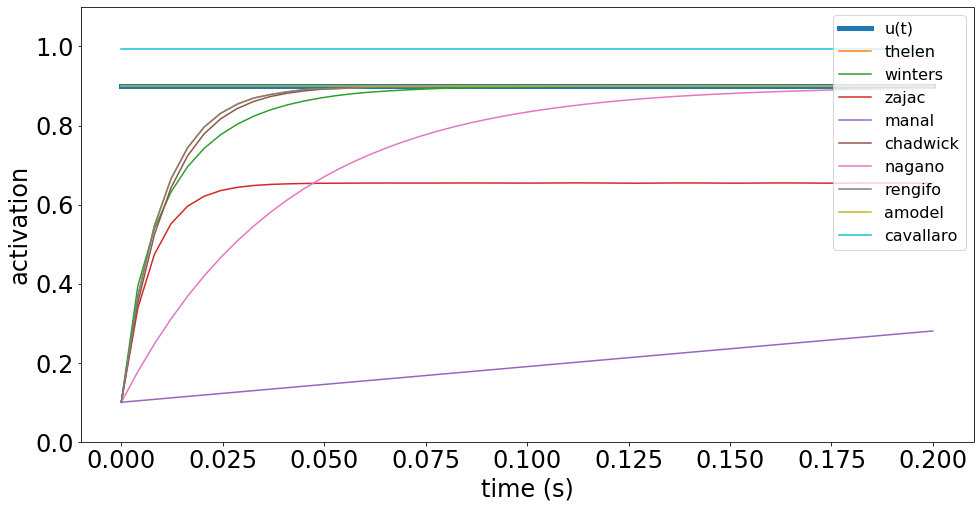

In [156]:
plt.figure(figsize=(16, 8))
plt.plot(t,u_array, label = 'u(t)', linewidth=5)
plt.plot(t,a_thelen, label = 'thelen')
plt.plot(t,a_winters, label = 'winters')
plt.plot(t,a_zajac, label = 'zajac')
plt.plot(t,a_manal, label = 'manal')
plt.plot(t,a_chadwick, label = 'chadwick')
plt.plot(t,a_nagano, label = 'nagano')
plt.plot(t,a_rengifo, label = 'rengifo')
plt.plot(t,a_amodel, label = 'amodel')
plt.plot(t,a_cavallaro, label = 'cavallaro')
plt.xlabel('time (s)', fontsize = 24)
plt.ylabel('activation', fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim(0, 1.1)
plt.legend(fontsize = 16, loc='upper right')
plt.show()
plt.close()

We see that there are two different types of models:  those that exhibit a time delay in matching the nueral input (those models return $\dot{a}(t)$) and those models that respond to input instantaneously (these models return $a(u)$ and are unphysical).

Let's do something a little more fancy.  Neural input is rarely ever a constant with time: your movements change as you respond to your changing environment.  So, let's trying hitting our activations again with an 'on-and-off' neural input -- like a step function throughout time -- to see how they respond.  We will follow the same code structure as above, however, here we will break up our time array into different 'bins' of nueral input being either on ($u(t) = 0.75$) or input being off ($u(t) = 0$).

In [157]:
# arrays for time and excitation values to live
t_array = np.array([0])
u_array = np.array([0])

# activation values for each of the activation functions above
a_thelen = np.array([0])
a_winters = np.array([0])
a_zajac = np.array([0])
a_manal = np.array([0])
a_chadwick = np.array([0])
a_nagano = np.array([0])
a_rengifo = np.array([0])
a_amodel = np.array([0])
a_cavallaro = np.array([0])

# need for loop to change excitation... basically discretizing 1 second into 100 sub-bins so that i can
# change the nueral input value in these bins... I then solve each activation model inside of these bins
f = 3
for i in range(f):
    i = i/f
    t = np.linspace(i, i + 1/f, 50)    # time array with 50 values between time i and i + 1/f
    t_array = np.concatenate((t_array, t), axis = None)    # update total time array
    
    # nueral excitation is zero unless this if statement hits (here it'll hit if we're between .33 and .66 seconds)
    if int(f*i) % 3 == 1: 
        u = np.ones(t.size) * 0.75
    else:
        u = np.zeros(t.size)
        
    # update excitation array
    u_array = np.concatenate((u_array, u), axis = None)
    
    # all models follow the same structure... first 
    act_thelen = Thelen(u_array[-1])
    sol = solve_ivp(act_thelen, [t[0], t[-1]], [a_thelen[-1]], t_eval=t)
    a_thelen = np.concatenate((a_thelen, sol.y.T), axis = None)
    
    act_winters = Winters(u_array[-1])
    sol = solve_ivp(act_winters, [t[0], t[-1]], [a_winters[-1]], t_eval=t)
    a_winters = np.concatenate((a_winters, sol.y.T), axis = None)
    
    act_zajac = Zajac(u_array[-1])
    sol = solve_ivp(act_zajac, [t[0], t[-1]], [a_zajac[-1]], t_eval=t)
    a_zajac = np.concatenate((a_zajac, sol.y.T), axis = None)
    
    act_manal = Manal(u_array[-1])
    sol = solve_ivp(act_manal, [t[0], t[-1]], [a_manal[-1]], t_eval=t)
    a_manal = np.concatenate((a_manal, sol.y.T), axis = None)
    
    act_chadwick = Chadwick(u_array[-1])
    sol = solve_ivp(act_chadwick, [t[0], t[-1]], [a_chadwick[-1]], t_eval=t)
    a_chadwick = np.concatenate((a_chadwick, sol.y.T), axis = None)
    
    act_nagano = Nagano(u_array[-1])
    sol = solve_ivp(act_nagano, [t[0], t[-1]], [a_nagano[-1]], t_eval=t)
    a_nagano = np.concatenate((a_nagano, sol.y.T), axis = None)
    
    act_rengifo = Rengifo(u_array[-1])
    sol = solve_ivp(act_rengifo, [t[0], t[-1]], [a_rengifo[-1]], t_eval=t)
    a_rengifo = np.concatenate((a_rengifo, sol.y.T), axis = None)
    
    act_amodel = AModel(u_array[-1])
    sol = np.ones(t.size) * act_amodel.a()
    a_amodel = np.concatenate((a_amodel, sol), axis = None)
    
    act_cavallaro = Cavallaro(u_array[-1])
    sol = np.ones(t.size) * act_cavallaro.a()
    a_cavallaro = np.concatenate((a_cavallaro, sol), axis = None)

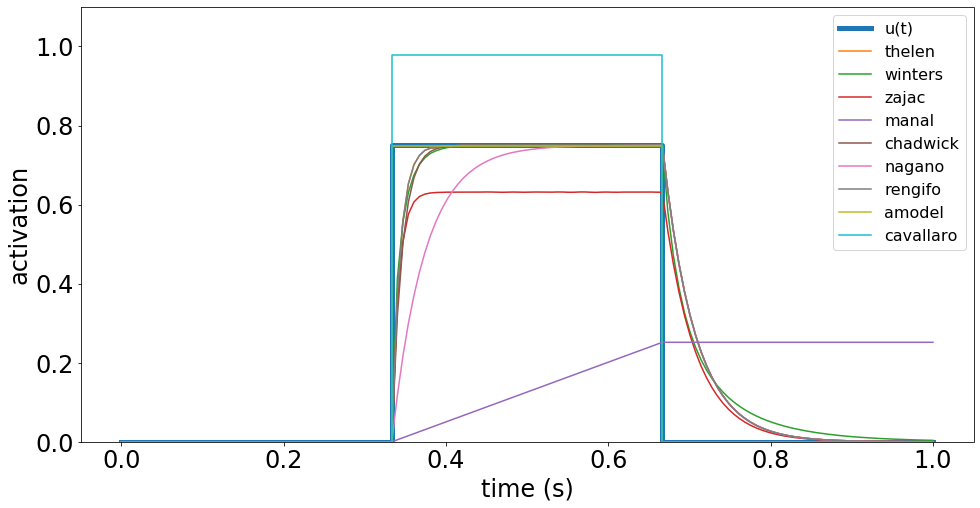

In [158]:
plt.figure(figsize=(16, 8))
plt.plot(t_array,u_array, label = 'u(t)', linewidth=5)
plt.plot(t_array,a_thelen, label = 'thelen')
plt.plot(t_array,a_winters, label = 'winters')
plt.plot(t_array,a_zajac, label = 'zajac')
plt.plot(t_array,a_manal, label = 'manal')
plt.plot(t_array,a_chadwick, label = 'chadwick')
plt.plot(t_array,a_nagano, label = 'nagano')
plt.plot(t_array,a_rengifo, label = 'rengifo')
plt.plot(t_array,a_amodel, label = 'amodel')
plt.plot(t_array,a_cavallaro, label = 'cavallaro')
plt.xlabel('time (s)', fontsize = 24)
plt.ylabel('activation', fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim(0, 1.1)
plt.legend(fontsize = 16, loc='upper right')
plt.show()
plt.close()

In the example above, $u(t) = 0$ for the first and last 1/3 of a second.  On the interval of $t \in [0.33,0.66]$, we have that $u(t) = 0.75$.  Here again we see that the activation timescale is quicker than the deactivation timescale.  This is due to the fact that to deactivate muscle, calcium ions must work against the concentration gradient.  Therefore, it takes them a longer time to leave the muscle-site.  We also see that each model responds a little differently to input.

Last demo with a more intense duty cycle of nueral input...

In [159]:
# arrays for time and excitation values to live
t_array = np.array([0])
u_array = np.array([0])

# activation values for each of the activation functions above
a_thelen = np.array([0])
a_winters = np.array([0])
a_zajac = np.array([0])
a_manal = np.array([0])
a_chadwick = np.array([0])
a_nagano = np.array([0])
a_rengifo = np.array([0])
a_amodel = np.array([0])
a_cavallaro = np.array([0])

# need for loop to change excitation... basically discretizing 1 second into 100 sub-bins so that i can
# change the nueral input value in these bins... I then solve each activation model inside of these bins
f = 20
for i in range(f):
    i = i/f
    t = np.linspace(i, i + 1/f, 50)    # time array with 50 values between time i and i + 1/f
    t_array = np.concatenate((t_array, t), axis = None)    # update total time array
    
    # nueral excitation is zero unless this if statement hits (here it'll hit if we're between .33 and .66 seconds)
    if int(f*i) % 2 == 1:
        u = np.ones(t.size) * 0.75
    else:
        u = np.zeros(t.size)
        
    # update excitation array
    u_array = np.concatenate((u_array, u), axis = None)
    
    # all models follow the same structure... first 
    act_thelen = Thelen(u_array[-1])
    sol = solve_ivp(act_thelen, [t[0], t[-1]], [a_thelen[-1]], t_eval=t)
    a_thelen = np.concatenate((a_thelen, sol.y.T), axis = None)
    
    act_winters = Winters(u_array[-1])
    sol = solve_ivp(act_winters, [t[0], t[-1]], [a_winters[-1]], t_eval=t)
    a_winters = np.concatenate((a_winters, sol.y.T), axis = None)
    
    act_zajac = Zajac(u_array[-1])
    sol = solve_ivp(act_zajac, [t[0], t[-1]], [a_zajac[-1]], t_eval=t)
    a_zajac = np.concatenate((a_zajac, sol.y.T), axis = None)
    
    act_manal = Manal(u_array[-1])
    sol = solve_ivp(act_manal, [t[0], t[-1]], [a_manal[-1]], t_eval=t)
    a_manal = np.concatenate((a_manal, sol.y.T), axis = None)
    
    act_chadwick = Chadwick(u_array[-1])
    sol = solve_ivp(act_chadwick, [t[0], t[-1]], [a_chadwick[-1]], t_eval=t)
    a_chadwick = np.concatenate((a_chadwick, sol.y.T), axis = None)
    
    act_nagano = Nagano(u_array[-1])
    sol = solve_ivp(act_nagano, [t[0], t[-1]], [a_nagano[-1]], t_eval=t)
    a_nagano = np.concatenate((a_nagano, sol.y.T), axis = None)
    
    act_rengifo = Rengifo(u_array[-1])
    sol = solve_ivp(act_rengifo, [t[0], t[-1]], [a_rengifo[-1]], t_eval=t)
    a_rengifo = np.concatenate((a_rengifo, sol.y.T), axis = None)
    
    act_amodel = AModel(u_array[-1])
    sol = np.ones(t.size) * act_amodel.a()
    a_amodel = np.concatenate((a_amodel, sol), axis = None)
    
    act_cavallaro = Cavallaro(u_array[-1])
    sol = np.ones(t.size) * act_cavallaro.a()
    a_cavallaro = np.concatenate((a_cavallaro, sol), axis = None)

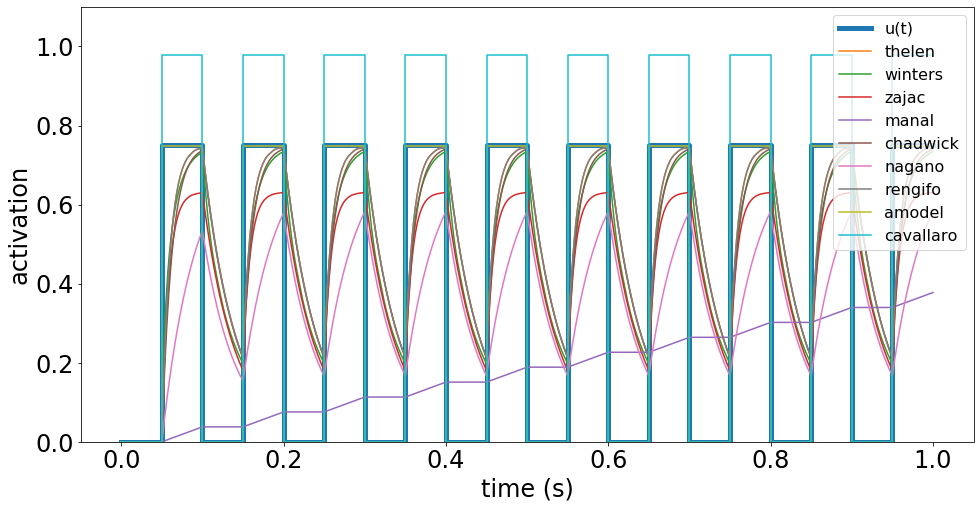

In [160]:
plt.figure(figsize=(16, 8))
plt.plot(t_array,u_array, label = 'u(t)', linewidth=5)
plt.plot(t_array,a_thelen, label = 'thelen')
plt.plot(t_array,a_winters, label = 'winters')
plt.plot(t_array,a_zajac, label = 'zajac')
plt.plot(t_array,a_manal, label = 'manal')
plt.plot(t_array,a_chadwick, label = 'chadwick')
plt.plot(t_array,a_nagano, label = 'nagano')
plt.plot(t_array,a_rengifo, label = 'rengifo')
plt.plot(t_array,a_amodel, label = 'amodel')
plt.plot(t_array,a_cavallaro, label = 'cavallaro')
plt.xlabel('time (s)', fontsize = 24)
plt.ylabel('activation', fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim(0, 1.1)
plt.legend(fontsize = 16, loc='upper right')
plt.show()
plt.close()

one last demo with random nueral input throughout one second

In [161]:
import random
# arrays for time and excitation values to live
t_array = np.array([0])
u_array = np.array([0])

# activation values for each of the activation functions above
a_thelen = np.array([0])
a_winters = np.array([0])
a_zajac = np.array([0])
a_manal = np.array([0])
a_chadwick = np.array([0])
a_nagano = np.array([0])
a_rengifo = np.array([0])
a_amodel = np.array([0])
a_cavallaro = np.array([0])

# need for loop to change excitation... basically discretizing 1 second into 100 sub-bins so that i can
# change the nueral input value in these bins... I then solve each activation model inside of these bins
f = 50
for i in range(f):
    i = i/f
    t = np.linspace(i, i + 1/f, 50)    # time array with 50 values between time i and i + 1/f
    t_array = np.concatenate((t_array, t), axis = None)    # update total time array
    
    # nueral excitation is zero unless this if statement hits (here it'll hit if we're between .33 and .66 seconds)
    u = np.ones(t.size) * random.random()
        
    # update excitation array
    u_array = np.concatenate((u_array, u), axis = None)
    
    # all models follow the same structure... first 
    act_thelen = Thelen(u_array[-1])
    sol = solve_ivp(act_thelen, [t[0], t[-1]], [a_thelen[-1]], t_eval=t)
    a_thelen = np.concatenate((a_thelen, sol.y.T), axis = None)
    
    act_winters = Winters(u_array[-1])
    sol = solve_ivp(act_winters, [t[0], t[-1]], [a_winters[-1]], t_eval=t)
    a_winters = np.concatenate((a_winters, sol.y.T), axis = None)
    
    act_zajac = Zajac(u_array[-1])
    sol = solve_ivp(act_zajac, [t[0], t[-1]], [a_zajac[-1]], t_eval=t)
    a_zajac = np.concatenate((a_zajac, sol.y.T), axis = None)
    
    act_manal = Manal(u_array[-1])
    sol = solve_ivp(act_manal, [t[0], t[-1]], [a_manal[-1]], t_eval=t)
    a_manal = np.concatenate((a_manal, sol.y.T), axis = None)
    
    act_chadwick = Chadwick(u_array[-1])
    sol = solve_ivp(act_chadwick, [t[0], t[-1]], [a_chadwick[-1]], t_eval=t)
    a_chadwick = np.concatenate((a_chadwick, sol.y.T), axis = None)
    
    act_nagano = Nagano(u_array[-1])
    sol = solve_ivp(act_nagano, [t[0], t[-1]], [a_nagano[-1]], t_eval=t)
    a_nagano = np.concatenate((a_nagano, sol.y.T), axis = None)
    
    act_rengifo = Rengifo(u_array[-1])
    sol = solve_ivp(act_rengifo, [t[0], t[-1]], [a_rengifo[-1]], t_eval=t)
    a_rengifo = np.concatenate((a_rengifo, sol.y.T), axis = None)
    
    act_amodel = AModel(u_array[-1])
    sol = np.ones(t.size) * act_amodel.a()
    a_amodel = np.concatenate((a_amodel, sol), axis = None)
    
    act_cavallaro = Cavallaro(u_array[-1])
    sol = np.ones(t.size) * act_cavallaro.a()
    a_cavallaro = np.concatenate((a_cavallaro, sol), axis = None)

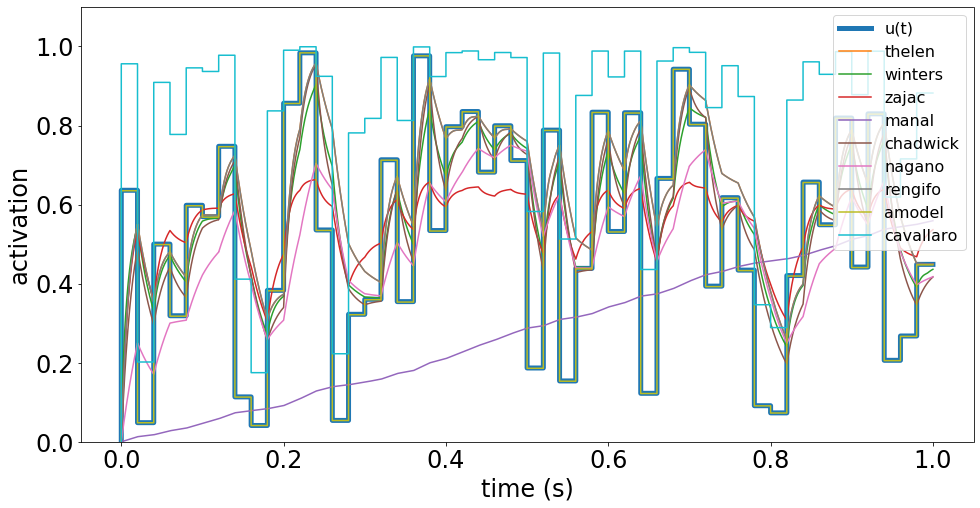

In [162]:
plt.figure(figsize=(16, 8))
plt.plot(t_array,u_array, label = 'u(t)', linewidth=5)
plt.plot(t_array,a_thelen, label = 'thelen')
plt.plot(t_array,a_winters, label = 'winters')
plt.plot(t_array,a_zajac, label = 'zajac')
plt.plot(t_array,a_manal, label = 'manal')
plt.plot(t_array,a_chadwick, label = 'chadwick')
plt.plot(t_array,a_nagano, label = 'nagano')
plt.plot(t_array,a_rengifo, label = 'rengifo')
plt.plot(t_array,a_amodel, label = 'amodel')
plt.plot(t_array,a_cavallaro, label = 'cavallaro')
plt.xlabel('time (s)', fontsize = 24)
plt.ylabel('activation', fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim(0, 1.1)
plt.legend(fontsize = 16, loc='upper right')
plt.show()
plt.close()